In [1]:
import torch
import torchvision 
import numpy as np
import matplotlib.pyplot as plt
import einops
from tqdm import tqdm

In [2]:
def imshow(img, figsize):
    if len(img.shape) == 4:
        img = img[0]
    
    if img.shape[0] == 3:
        img = einops.rearrange(img, "c h w -> h w c", c = 3)
    
    plt.figure(figsize=figsize)
    plt.imshow(img)

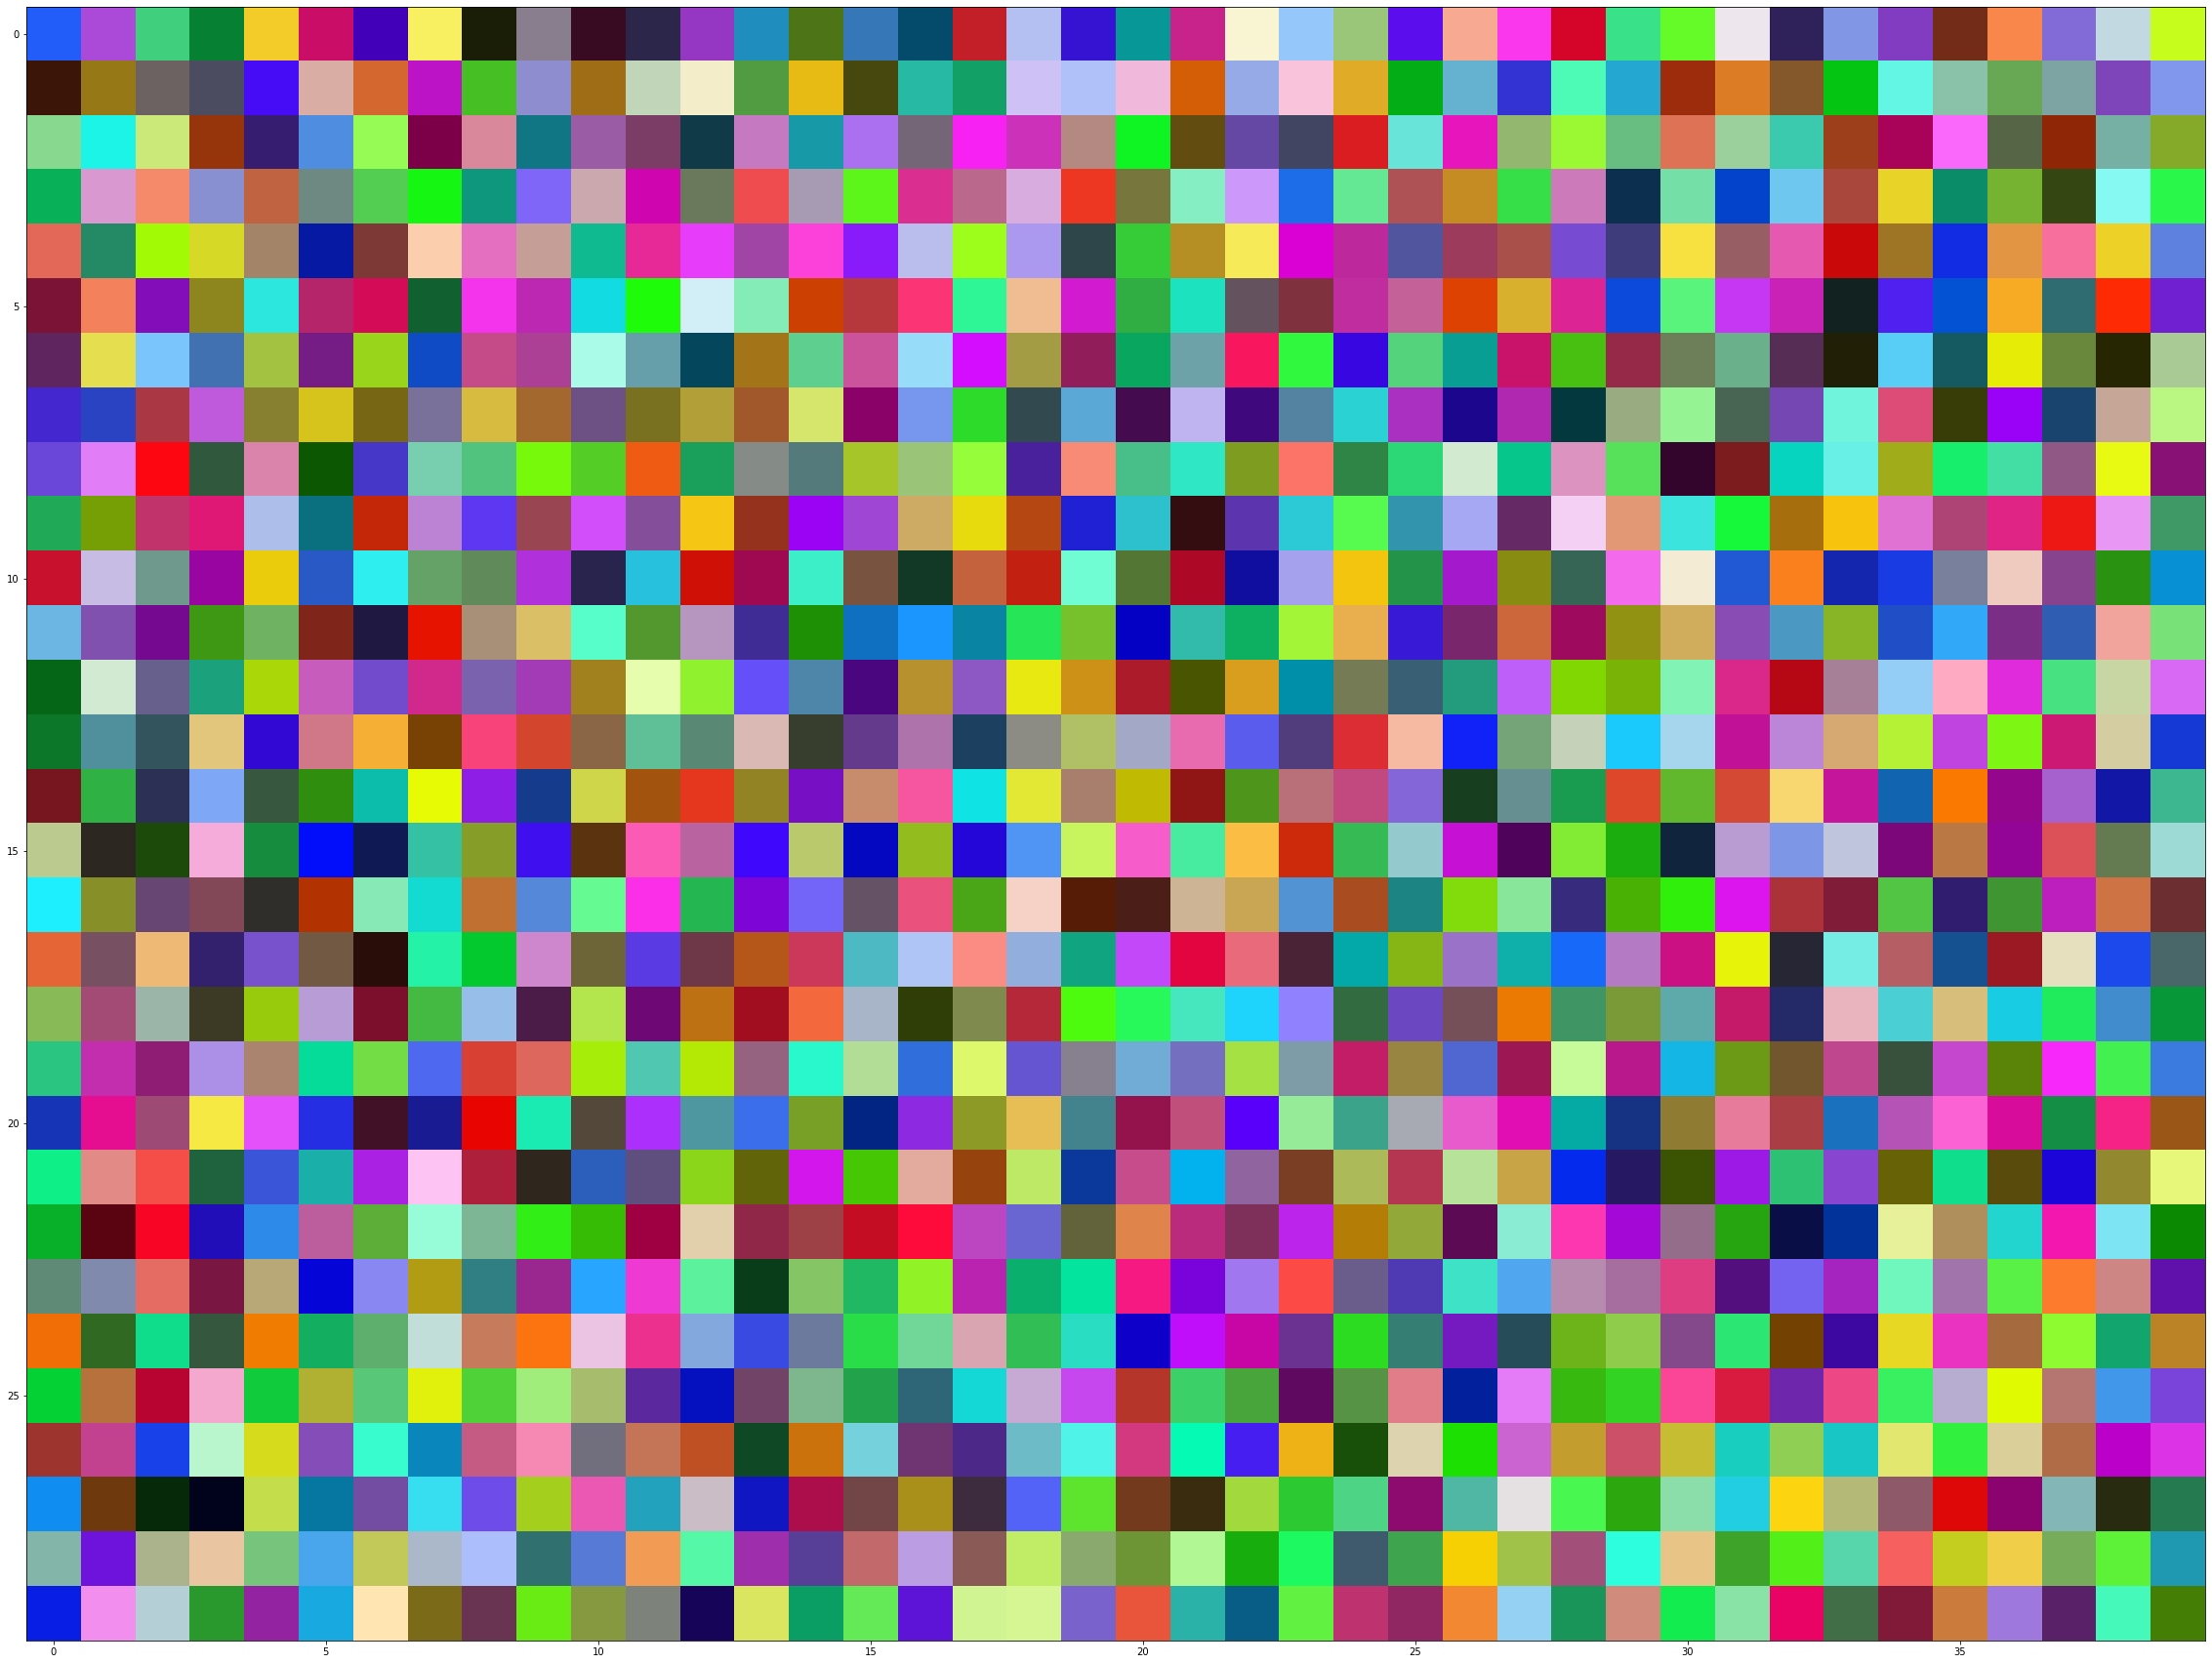

In [5]:
arr = np.random.rand(30,40,3)

imshow(arr, (40, 50))

In [15]:
class OptimisedImageClipped(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.random_ass_name = torch.nn.parameter.Parameter(torch.rand(1, 3, 244, 244))

    def forward(self):
        return torch.clamp(self.random_ass_name, min=0, max=1)

In [16]:
def train(model, img, logit=50, lr=0.05, epochs=10):
    optimizer = torch.optim.Adam(img.parameters(), lr=lr)
    loss_vals = []
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss = -model(img())[0,logit]
        loss.backward()
        optimizer.step()
        loss_vals.append(float(loss))
    
    return img, loss_vals

In [17]:
model = torchvision.models.resnet34(pretrained=True)
model.eval()
model.cuda()

def visualize(train=train, img=OptimisedImageClipped(), epochs=10, lr=0.05, figsize=(5,5)):
    imshow(img().detach().cpu(), figsize)
    try:
        train(model, img.cuda(), epochs=epochs, lr=lr)
    except KeyboardInterrupt:
        imshow(img().detach().cpu(), figsize)
    imshow(img().detach().cpu(), figsize)

100%|██████████| 1000/1000 [00:18<00:00, 53.39it/s]


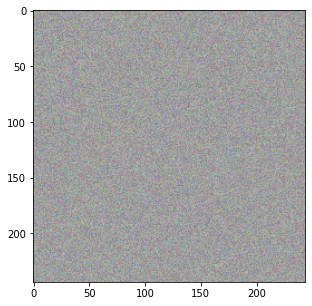

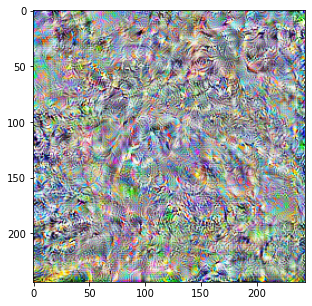

In [18]:
class OptimisedImageSigmoid(OptimisedImageClipped):
    def forward(self):
        return torch.sigmoid(self.random_ass_name)

visualize(train=train, img=OptimisedImageSigmoid(), epochs=1_000)

In [19]:
def train_with_transform(model, img, logit=50, lr=0.05, epochs=100):
    optimizer = torch.optim.Adam(img.parameters(), lr=lr)
    transforms = torch.nn.Sequential(
        torchvision.transforms.RandomAffine(5, translate=(0.01, 0.01)),
        torchvision.transforms.ColorJitter(),
    )
    scripted_transforms = torch.jit.script(transforms)
    loss_vals = []
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss = -model(scripted_transforms(img()))[0,logit]
        loss.backward()
        optimizer.step()
        loss_vals.append(float(loss))
    
    return img, loss_vals

100%|██████████| 1000/1000 [00:21<00:00, 46.91it/s]


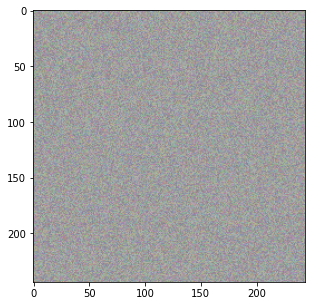

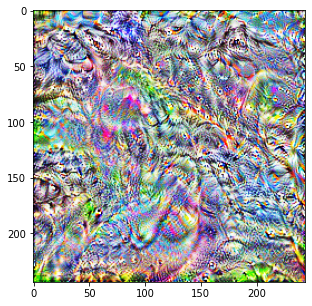

In [20]:
visualize(train=train_with_transform, img=OptimisedImageSigmoid(), epochs=1_000)

In [27]:
class OptimizedImageFourier(torch.nn.Module):
    def __init__(self, scale=50) -> None:
        super().__init__()
        self.scale = scale
        self.freq_params = torch.nn.parameter.Parameter(torch.randn(1, 3, 244, 113, 2))

    def forward(self):
        return torch.sigmoid(self.scale*torch.fft.irfft2(torch.view_as_complex(self.freq_params)))


100%|██████████| 1000/1000 [00:19<00:00, 50.27it/s]


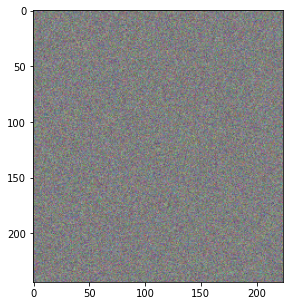

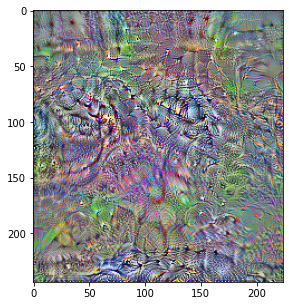

In [29]:
visualize(train=train_with_transform, img=OptimizedImageFourier(), lr=0.1, epochs=1_000)

In [30]:
class OptimizedImageFourierNormalised(torch.nn.Module):
    def __init__(self, scale=20) -> None:
        super().__init__()
        self.scale = scale
        fx = torch.fft.fftfreq(113)
        fy = torch.fft.fftfreq(244)

        norm = torch.sqrt(fx ** 2) + torch.sqrt(fy ** 2).unsqueeze(1)  # [113] + [244, 1] -> [1, 113] + [244, 1] -> [244, 113]
        norm[0][0] = 1 / 244.0

        self.register_buffer("normalisation_const", norm, persistent=True)
        
        self.freq_params = torch.nn.parameter.Parameter(torch.randn(1, 3, 244, 113, 2))

    def forward(self):
        return torch.sigmoid(self.scale * torch.fft.irfft2(torch.view_as_complex(self.freq_params) / self.normalisation_const))

100%|██████████| 1000/1000 [00:20<00:00, 49.95it/s]


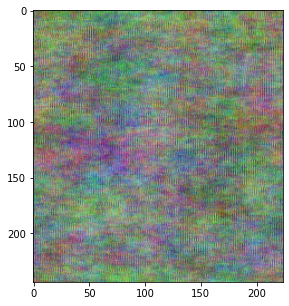

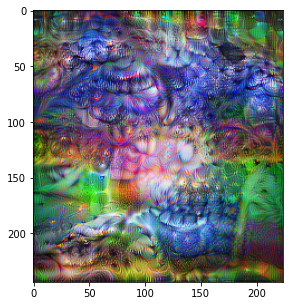

In [32]:
visualize(train=train_with_transform, img=OptimizedImageFourierNormalised(), lr=0.05, epochs=1_000)

In [72]:
class OptimizeImageCorrelatedRGB(torch.nn.Module):
    def __init__(self, scale = 50, device=torch.device('cuda')) -> None:
        super().__init__()
        self.scale = scale
        self.params = torch.nn.parameter.Parameter(torch.rand(1, 3, 244, 244))
        self.register_buffer("correlations", torch.Tensor([
            [ 0.56282854,  0.19482528,  0.0432945 ],
            [ 0.5844758,   0.,         -0.10823626],
            [ 0.5844758,  -0.19482528,  0.06494176]
        ]))

    def forward(self):
        correlated = torch.einsum("ci,bihw->bchw", self.correlations, self.params)
        return torch.sigmoid(correlated * self.scale)

100%|██████████| 1000/1000 [00:20<00:00, 48.79it/s]


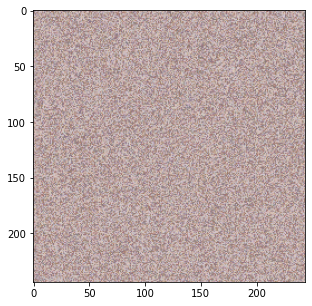

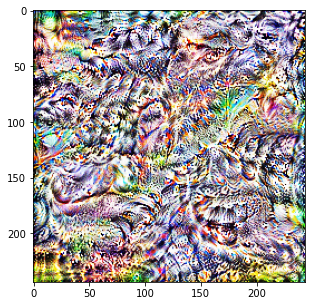

In [74]:
visualize(train=train_with_transform, img=OptimizeImageCorrelatedRGB(scale=2.5), lr=0.05, epochs=1_000)

In [47]:
class OptimizedImageFourierNormalisedCorrelated(torch.nn.Module):
    def __init__(self, scale=50) -> None:
        super().__init__()
        self.scale = scale
        self.freq_params = torch.nn.parameter.Parameter(torch.randn(1, 3, 224, 113, 2))
        self.register_buffer("correlations", torch.Tensor([
            [ 0.56282854,  0.19482528,  0.0432945 ],
            [ 0.5844758,   0.,         -0.10823626],
            [ 0.5844758,  -0.19482528,  0.06494176]
        ]))

        fx = torch.fft.fftfreq(113)
        fy = torch.fft.fftfreq(224)

        norm = torch.sqrt(fx ** 2) + torch.sqrt(fy ** 2).unsqueeze(1)  # [113] + [224, 1] -> [1, 113] + [224, 1] -> [224, 113]
        norm[0][0] = 1 / 224.0

        self.register_buffer("normalisation_const", norm, persistent=True)

    def forward(self):
        decorrelated = torch.fft.irfft2(torch.view_as_complex(self.freq_params) / self.normalisation_const)
        correlated = torch.einsum("ci,bihw->bchw", self.correlations, decorrelated)
        return torch.sigmoid(self.scale * correlated)

100%|██████████| 3000/3000 [01:02<00:00, 48.15it/s]


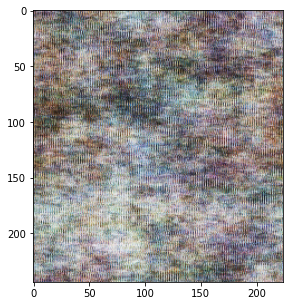

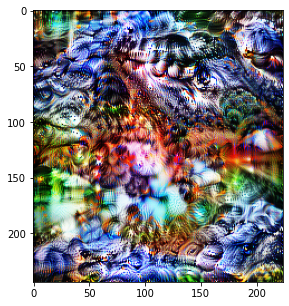

In [21]:
visualize(train=train_with_transform, img=OptimizedImageFourierNormalisedCorrelated(scale=50), lr=0.05, epochs=3_000)

In [86]:
OptimizedImageFourierNormalisedCorrelated().__class__.__name__

'OptimizedImageFourierNormalisedCorrelated'

100%|██████████| 200/200 [00:02<00:00, 72.34it/s]


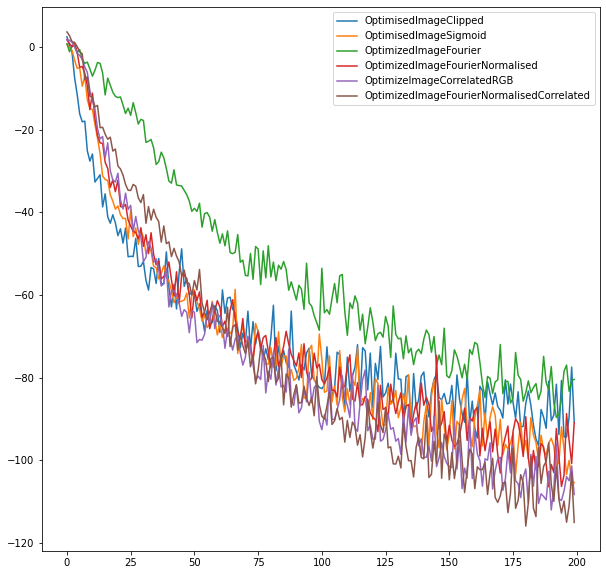

In [94]:
plt.figure(figsize=(10, 10))

for img in [
    OptimisedImageClipped(),
    OptimisedImageSigmoid(),
    OptimizedImageFourier(),
    OptimizedImageFourierNormalised(),
    OptimizeImageCorrelatedRGB(scale=2.5),
    OptimizedImageFourierNormalisedCorrelated(scale=50)
    ]:
    _, loss = train_with_transform(model, img.cuda(), logit=50, lr=0.05, epochs=200)
    plt.plot(loss, label=img.__class__.__name__)

plt.legend(loc="upper right")
plt.show()

In [7]:
def train_with_hook(model, img, layer, logit, lr=0.05, epochs=10):
    print(type(layer))
    global activation
    activation = None
    def forward_hook(module, module_inputs, module_outputs):
        (-module_outputs)[logit].backward()
    layer.register_forward_hook(forward_hook)
    optimizer = torch.optim.Adam(img.parameters(), lr=lr)
    loss_vals = []
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        model(img())
        optimizer.step()
    
    return img, loss_vals

def visualize_with_hook(model, layer, logit, train=train_with_hook, img=OptimizedImageFourierNormalisedCorrelated(), epochs=10, lr=0.05, figsize=(5,5), save_fig=False, fig_name="lol"):
    imshow(img().detach().cpu(), figsize)
    try:
        train(model, img.cuda(), layer=layer, logit=logit, epochs=epochs, lr=lr)
    except KeyboardInterrupt:
        imshow(img().detach().cpu(), figsize)
    imshow(img().detach().cpu(), figsize)

    if save_fig:
        plt.savefig(fig_name)

<class 'torch.nn.modules.conv.Conv2d'>


100%|██████████| 1/1 [00:00<00:00, 73.99it/s]

LOOOL


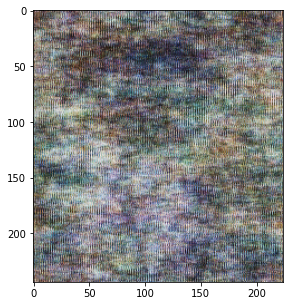

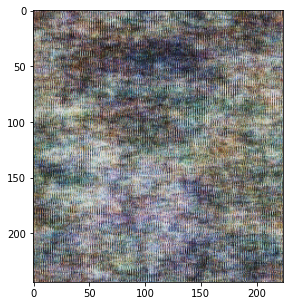

In [193]:
model = torchvision.models.resnet34(pretrained=True)
model.eval()
model.cuda()
visualize_with_hook(model, model.layer4[0].conv2, (0,25,5,5) ,train=train_with_hook, img=OptimizedImageFourierNormalisedCorrelated(scale=50), epochs=1)

100%|██████████| 3000/3000 [00:58<00:00, 50.89it/s]


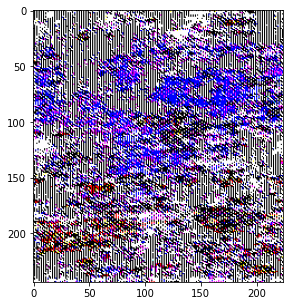

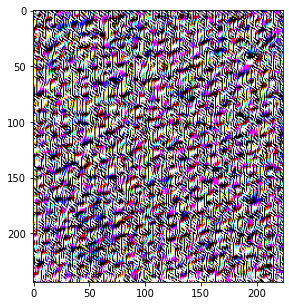

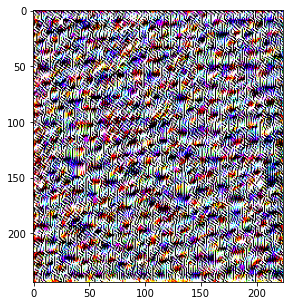

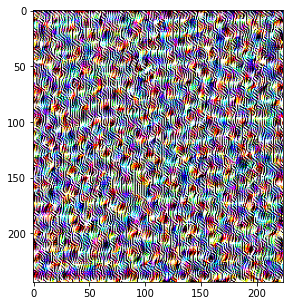

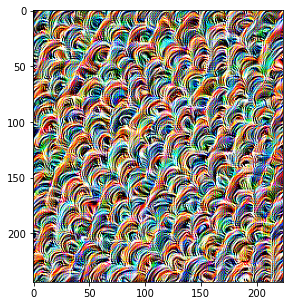

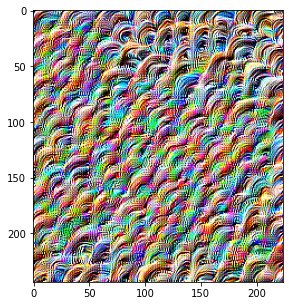

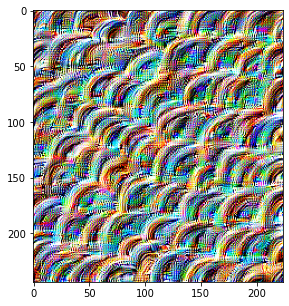

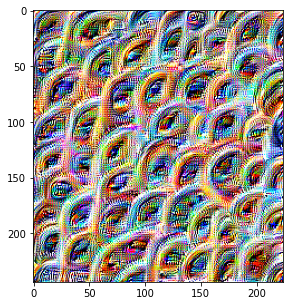

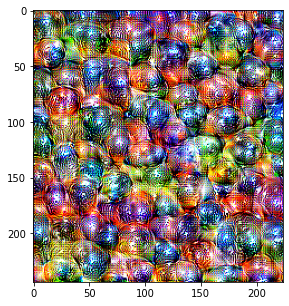

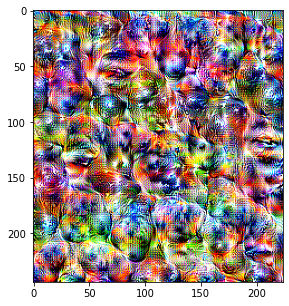

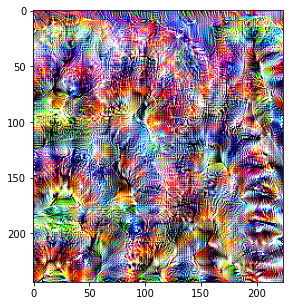

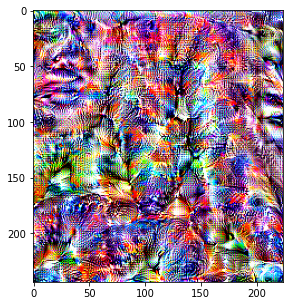

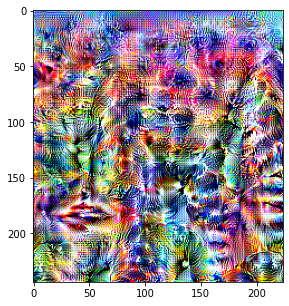

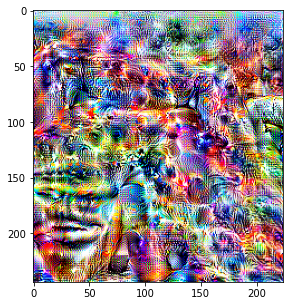

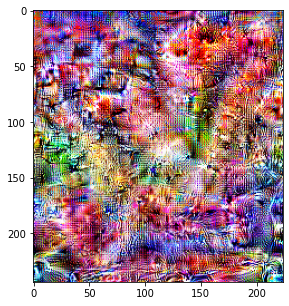

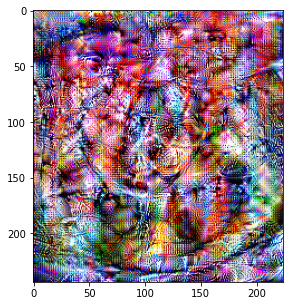

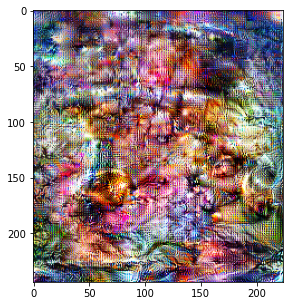

In [9]:
class ModuleHook:
    def __init__(self) -> None:
        self.module_outputs = None

    def __call__(self, module, module_inputs, module_outputs):
        self.module_outputs = module_outputs

def train_with_hook_channels(model, img, layer, lr=0.05, epochs=10, logit=None,):
    hook = ModuleHook()
    handle = layer.register_forward_hook(hook)
    optimizer = torch.optim.Adam(img.parameters(), lr=lr)
    loss_vals = []
    for _ in tqdm(range(epochs)):
        optimizer.zero_grad()
        model(img())
        loss = -torch.sum(hook.module_outputs[:, :10, :, :] ** 2, dim=[-3, -2, -1])
        loss.backward()
        optimizer.step()

    handle.remove()
    
    return img, loss_vals

def visualize_with_hook_channels(model, layer, logit, img=OptimizedImageFourierNormalisedCorrelated(), epochs=10, lr=0.05, figsize=(5,5), save_fig=False, fig_name="lol"):
    try:
        train_with_hook_channels(model, img.cuda(), layer=layer, logit=logit, epochs=epochs, lr=lr)
    except KeyboardInterrupt:
        imshow(img().detach().cpu(), figsize)
    imshow(img().detach().cpu(), figsize)

    if save_fig:
        plt.savefig(fig_name)

def get_relu_layers(model):
    return list(filter(lambda layer: isinstance(layer, torch.nn.ReLU), [layer for layer in model.modules()]))

for i in range(10):
    resnet_model = torchvision.models.resnet34(pretrained=True)
    resnet_model.eval()
    resnet_model.cuda()
    relu_layers = get_relu_layers(resnet_model)
    visualize_with_hook_channels(resnet_model, relu_layers[i], logit=None, img=OptimizedImageFourierNormalisedCorrelated(scale=50), epochs=1_000, save_fig=True, fig_name=f"resnet_relu_visualisations/relu_layer_{i}.png")
for i in range(10,15):
    resnet_model = torchvision.models.resnet34(pretrained=True)
    resnet_model.eval()
    resnet_model.cuda()
    relu_layers = get_relu_layers(resnet_model)
    visualize_with_hook_channels(resnet_model, relu_layers[i], logit=None, img=OptimizedImageFourierNormalisedCorrelated(scale=50), epochs=2_000, save_fig=True, fig_name=f"resnet_relu_visualisations/relu_layer_{i}.png")
for i in range(15,17):
    resnet_model = torchvision.models.resnet34(pretrained=True)
    resnet_model.eval()
    resnet_model.cuda()
    relu_layers = get_relu_layers(resnet_model)
    visualize_with_hook_channels(resnet_model, relu_layers[i], logit=None, img=OptimizedImageFourierNormalisedCorrelated(scale=50), epochs=3_000, save_fig=True, fig_name=f"resnet_relu_visualisations/relu_layer_{i}.png")


In [51]:
from PIL import Image
import requests
from io import BytesIO
from torchvision import transforms


def load_image(url):
  response = requests.get(url)
  return Image.open(BytesIO(response.content))

def get_target(model, url, relu_layer_idx=8):
    image = load_image(url)
    model = torchvision.models.resnet34(pretrained=True)
    model.eval()
    model.cuda()
    inputs = transforms.ToTensor()(image).unsqueeze_(0).cuda()
    layer = get_relu_layers(model)[relu_layer_idx]
    hook = ModuleHook()
    handle = layer.register_forward_hook(hook)
    model(inputs)
    target = hook.module_outputs
    handle.remove()
    return target

model = torchvision.models.resnet34(pretrained=True)
model.eval()
model.cuda()
relu_layers = get_relu_layers(model)
handle = layer.register_forward_hook(hook)

img = OptimizedImageFourierNormalisedCorrelated(scale=50).cuda()
optimizer = torch.optim.Adam(img.parameters(), lr=lr)
for _ in tqdm(range(epochs)):
    optimizer.zero_grad()
    # print("img().shape", img().shape)
    model(img())
    print(hook.module_outputs.shape, target.shape)
    loss = -torch.sum((hook.module_outputs - target) ** 2, dim=(-3,-2,-1))
    loss.backward()
    optimizer.step()

handle.remove()




inputs.shape torch.Size([1, 3, 224, 224])


  1%|          | 1/100 [00:00<00:03, 29.88it/s]

torch.Size([1, 256, 14, 14]) torch.Size([1, 256, 14, 14])
torch.Size([1, 256, 14, 14]) torch.Size([1, 256, 14, 14])


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

torch.Size([1, 3, 224, 224])